100%|██████████| 197/197 [00:58<00:00,  3.39it/s]


Epoch 1, Loss: 3.4483
Validation Accuracy: 38.40%


100%|██████████| 197/197 [00:58<00:00,  3.39it/s]


Epoch 2, Loss: 2.1694
Validation Accuracy: 55.20%


100%|██████████| 197/197 [00:57<00:00,  3.40it/s]


Epoch 3, Loss: 1.6848
Validation Accuracy: 63.80%


100%|██████████| 197/197 [01:01<00:00,  3.20it/s]


Epoch 4, Loss: 1.3728
Validation Accuracy: 69.80%


100%|██████████| 197/197 [00:57<00:00,  3.43it/s]


Epoch 5, Loss: 1.1490
Validation Accuracy: 72.60%


100%|██████████| 197/197 [01:08<00:00,  2.88it/s]


Epoch 6, Loss: 1.0023
Validation Accuracy: 76.20%


100%|██████████| 197/197 [01:00<00:00,  3.27it/s]


Epoch 7, Loss: 0.8649
Validation Accuracy: 73.60%


100%|██████████| 197/197 [00:50<00:00,  3.89it/s]


Epoch 8, Loss: 0.7461
Validation Accuracy: 76.40%


100%|██████████| 197/197 [00:56<00:00,  3.47it/s]


Epoch 9, Loss: 0.6514
Validation Accuracy: 79.80%


100%|██████████| 197/197 [01:01<00:00,  3.19it/s]


Epoch 10, Loss: 0.5757
Validation Accuracy: 79.60%
Test Accuracy: 79.00%


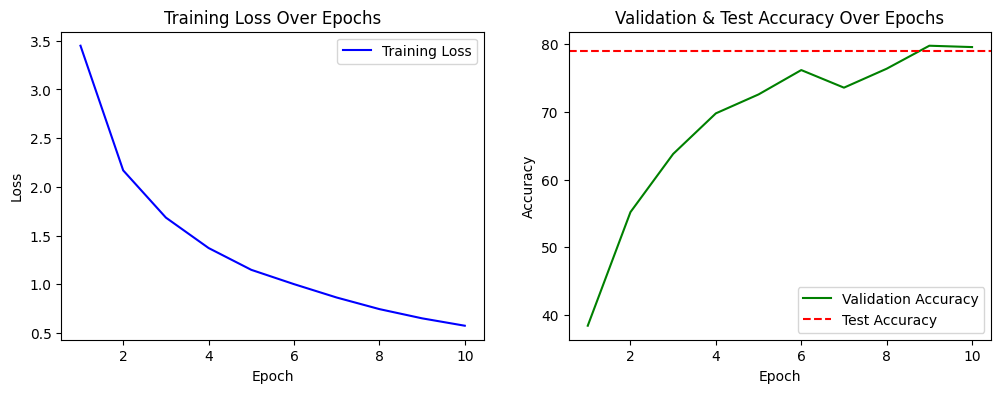

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class CNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = ImageFolder(root='E:/archive/train', transform=transform)
val_dataset = ImageFolder(root='E:/archive/valid', transform=transform)
test_dataset = ImageFolder(root='E:/archive/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


model = CNN(num_classes=len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


def train(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    train_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
        
      
        val_accuracy = evaluate(model, val_loader)
        val_accuracies.append(val_accuracy)
        print(f"Validation Accuracy: {val_accuracy:.2f}%")
    
    return train_losses, val_accuracies

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test(model, test_loader):
    test_accuracy = evaluate(model, test_loader)
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    return test_accuracy


epochs = 10
train_losses, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, epochs)
test_accuracy = test(model, test_loader)


plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation & Test Accuracy Over Epochs')
plt.legend()

plt.show()
